In [ ]:
import pandas as pd
import sqlite3

# Load data from CSV (or Excel sheets)
customers = pd.read_csv("customers.csv")
orders = pd.read_csv("orders.csv")
web_events = pd.read_csv("web_events.csv")
ad_spend = pd.read_csv("ad_spend.csv")

In [ ]:
# Connect to SQLite (local DB file)
conn = sqlite3.connect("urbanwear.db")

In [ ]:
# Load into SQLite
customers.to_sql("customers", conn, if_exists="replace", index=False)
orders.to_sql("orders", conn, if_exists="replace", index=False)
web_events.to_sql("web_events", conn, if_exists="replace", index=False)
ad_spend.to_sql("ad_spend", conn, if_exists="replace", index=False)

540

**Build Dimensional Models**

In [ ]:
queries = {
"dim_customers": """
    CREATE TABLE dim_customers AS
    SELECT customer_id, DATE(signup_date) as signup_date
    FROM customers
""",
"fct_orders": """
    CREATE TABLE fct_orders AS
    SELECT order_id, customer_id, DATE(order_date) as order_date, total_revenue
    FROM orders
"""
}

cur = conn.cursor()
for name, sql in queries.items():
    cur.execute(f"DROP TABLE IF EXISTS {name}")
    cur.execute(sql)
conn.commit()

# **Analytics Models**

# **RFM Segmentation**

In [ ]:
# RFM Calculation
orders['order_date'] = pd.to_datetime(orders['order_date']) # order_date column is in date format so you can calculate time differences correctly
rfm_base = orders.groupby("customer_id").agg(
    recency=('order_date', lambda x: (pd.Timestamp.today() - x.max()).days), #(today - most recent order_date) in days. Smaller = more recent = better customer.
    frequency=("order_id", "nunique"), # Number of unique orders made (nunique). More = more loyal.
    monetary=("total_revenue", "sum") #Total revenue contributed by the customer. Higher = more valuable.
).reset_index()

# RFM Scores. Splits data into quartiles (4 equal groups).
rfm_base["r_score"] = pd.qcut(rfm_base["recency"], 4, labels=[4,3,2,1]) # lower is better → Labels are [4,3,2,1]. most recent buyers get score 4, oldest buyers get score 1.
rfm_base["f_score"] = pd.qcut(rfm_base["frequency"], 4, duplicates='drop').cat.codes + 1 # higher is better → Codes assigned in ascending order and then +1 ensures range starts from 1.
rfm_base["m_score"] = pd.qcut(rfm_base["monetary"], 4, duplicates='drop').cat.codes + 1 # higher is better → Codes assigned in ascending order and then +1 ensures range starts from 1.

def segment_customer(row):
    if row.r_score >= 4 and row.f_score >= 4 and row.m_score >= 4:
        return "Champions - High Value"
    elif row.r_score >= 3 and row.f_score >= 3 and row.m_score >= 3:
        return "Loyal & Valuable"
    elif row.r_score >= 4 and row.f_score <= 2 and row.m_score >= 3:
        return "New High-Spenders"
    elif row.r_score <= 2 and row.f_score >= 4 and row.m_score >= 3:
        return "At Risk but Valuable"
    elif row.r_score <= 2 and row.f_score <= 2 and row.m_score <= 2:
        return "Lost Low Value"
    else:
        return "Regular"

# So now each customer has:
# r_score (1–4)
# f_score (1–4)
# m_score (1–4)
rfm_base["customer_segment"] = rfm_base.apply(segment_customer, axis=1)
rfm_base.head(5)


,customer_id,recency,frequency,monetary,r_score,f_score,m_score,customer_segment
0,1001,242,2,888,1,1,4,Regular
1,1003,180,2,620,4,1,4,New High-Spenders
2,1004,214,1,429,2,1,3,Regular
3,1005,207,2,816,3,1,4,Regular
4,1006,265,1,67,1,1,1,Lost Low Value


In [ ]:
# Group by R, F, M scores and segment
rfm_distribution = (
    rfm_base.groupby(["r_score", "f_score", "m_score", "customer_segment"])
    .size()
    .reset_index(name="num_customers")
    .sort_values("num_customers", ascending=False)
)

print(rfm_distribution.head(10))

   r_score  f_score  m_score   customer_segment  num_customers
72       1        1        1     Lost Low Value              5
56       2        1        3            Regular              5
7        4        1        3  New High-Spenders              4
5        4        1        2            Regular              4
48       2        1        1     Lost Low Value              4
51       2        1        2     Lost Low Value              4
10       4        1        4  New High-Spenders              4
26       3        1        1            Regular              4
80       1        1        3            Regular              4
75       1        1        2     Lost Low Value              4


/tmp/ipython-input-517873766.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rfm_base.groupby(["r_score", "f_score", "m_score", "customer_segment"])


# **RFM Segmentation Insights and Recommendations**

*   **Insight:** The RFM distribution shows that a significant number of customers fall into the 'Lost Low Value' segment, indicating a need to understand why these customers are not making repeat purchases and if re-engagement efforts are worthwhile. Conversely, the 'New High-Spenders' and 'Champions' segments are valuable and should be nurtured.
*   **Recommendation:**
    *   Analyze the characteristics of 'Lost Low Value' customers to identify potential reasons for churn.
    *   Develop targeted strategies to re-engage 'Lost Low Value' customers, potentially with different approaches based on their historical behavior.
    *   Implement loyalty programs or exclusive offers for 'Champions' and 'New High-Spenders' to encourage continued engagement and maximize their lifetime value.

# **Last-Touch Marketing Attribution**

In [ ]:
# Merge last non-null utm_source for each customer before their order

orders['order_date'] = pd.to_datetime(orders['order_date']) # Converts order and event timestamps to datetime
web_events['event_timestamp'] = pd.to_datetime(web_events['event_timestamp']) # Converts order and event timestamps to datetime

attribution_list = []

for index, order in orders.sort_values("order_date").iterrows(): #Loops through each order in chronological order (oldest → newest).
    customer_id = order['customer_id']
    order_date = order['order_date']

    # Find web events for the same customer before the order date with non-null utm_source
    customer_web_events = web_events[
        (web_events['customer_id'] == customer_id) &
        (web_events['event_timestamp'] <= order_date) &
        (web_events['utm_source'].notna())
    ].sort_values('event_timestamp')

# Takes only that customer’s web events / Keeps events that happened before or on the order date / Drops rows where utm_source is null/Sorts remaining events by time.

    last_touch_source = None # If no such events → utm_source remains None.
    if not customer_web_events.empty: #If there are valid web events before the order → take the last one (iloc[-1]).
        last_touch_source = customer_web_events['utm_source'].iloc[-1]

    attribution_list.append({
        "order_id": order['order_id'],
        "customer_id": customer_id,
        "total_revenue": order['total_revenue'],
        "utm_source": last_touch_source
    })

attribution = pd.DataFrame(attribution_list)
attribution

,order_id,customer_id,total_revenue,utm_source
0,55,1029,351,None
1,68,1006,67,None
2,15,1072,420,None
3,67,1057,177,None
4,17,1034,71,None
...,...,...,...,...
95,89,1062,442,facebook
96,58,1032,148,facebook
97,45,1051,207,linkedin
98,20,1023,87,linkedin


# **Last-Touch Marketing Attribution Insights and Recommendations**

*   **Insight:** The last-touch attribution model and the visualization show that some channels are more effective at driving the final conversion than others. The bar chart clearly illustrates the distribution of last touches across different marketing channels.
*   **Recommendation:**
    *   Prioritize investment in the channels that demonstrate a high number of last touches and contribute significantly to revenue, as shown in the attribution table and the bar plot.
    *   Analyze the customer journey for channels with fewer last touches to understand their role in earlier stages of the funnel.
    *   Consider exploring multi-touch attribution models to gain a more complete understanding of channel performance across the entire customer journey.

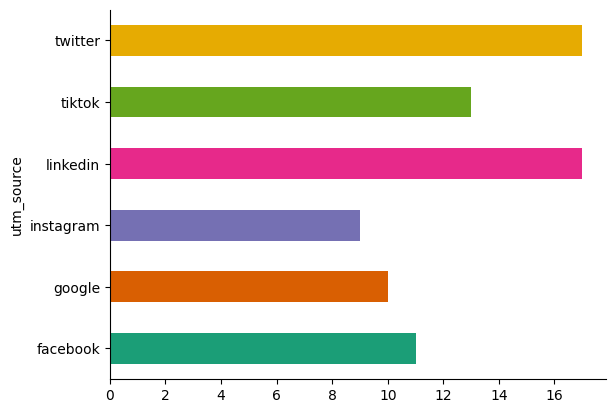

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
attribution.groupby('utm_source').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

# **ROAS (Return on Ad Spend)**

In [ ]:
revenue_by_channel = attribution.groupby("utm_source")["total_revenue"].sum().reset_index()
roas_df = ad_spend.merge(revenue_by_channel, left_on="source", right_on="utm_source", how="left")
roas_df["roas"] = roas_df["total_revenue"] / roas_df["spend"]
roas_df.drop (columns=["source"], inplace=True)
display(roas_df)

,date,spend,clicks,impressions,utm_source,total_revenue,roas
0,2025-01-01,975,425,1442,google,2726,2.795897
1,2025-01-01,124,94,10370,facebook,2888,23.290323
2,2025-01-01,412,497,17346,instagram,2464,5.980583
3,2025-01-01,1307,100,19693,tiktok,3897,2.981637
4,2025-01-01,174,448,3169,twitter,5312,30.528736
...,...,...,...,...,...,...,...
535,2025-03-31,826,327,6208,facebook,2888,3.496368
536,2025-03-31,737,67,14223,instagram,2464,3.343284
537,2025-03-31,1472,155,10486,tiktok,3897,2.647418
538,2025-03-31,880,216,8692,twitter,5312,6.036364


In [ ]:
# --- Step 1: Aggregate revenue by channel ---
revenue_by_channel = (
    attribution.groupby("utm_source", as_index=False)["total_revenue"]
    .sum()
)

# --- Step 2: Aggregate spend by channel ---
spend_by_channel = (
    ad_spend.groupby("source", as_index=False)["spend"]
    .sum()
)

# --- Step 3: Merge spend and revenue ---
roas_df = spend_by_channel.merge(
    revenue_by_channel,
    left_on="source",
    right_on="utm_source",
    how="left"
)

# --- Step 4: Clean up and calculate ROAS ---
roas_df["total_revenue"] = roas_df["total_revenue"].fillna(0)
roas_df["roas"] = roas_df.apply(
    lambda row: row["total_revenue"] / row["spend"] if row["spend"] > 0 else 0,
    axis=1
)

# --- Step 5: Final selection ---
roas_df = roas_df[["source", "spend", "total_revenue", "roas"]]

print(roas_df)


      source  spend  total_revenue      roas
0   facebook  64285           2888  0.044925
1     google  69582           2726  0.039177
2  instagram  61697           2464  0.039937
3   linkedin  72540           4024  0.055473
4     tiktok  79878           3897  0.048787
5    twitter  68913           5312  0.077083


# **ROAS Insights**

**1. ROAS is very low across the board**

All ROAS values are well below 1.

This means for every ₹1 spent, you’re making < ₹0.08 back.

Business is losing money heavily on all channels.

**2. Best Performing Channel: Twitter**

Highest ROAS = 0.077.

Still unprofitable, but relatively the most efficient channel.

Generated ₹5,312 revenue on ₹68,913 spend.

If optimized, could be a channel worth testing further.

**3. Worst Performing Channel: Google**

Lowest ROAS = 0.039.

High spend (₹69,582) but low revenue (₹2,726).

Indicates poor targeting or ineffective campaigns.

**4. LinkedIn Shows Slightly Better ROI**

ROAS = 0.055, second best after Twitter.

Generated the highest revenue (₹4,024) after Twitter.

Might be more effective for B2B or professional audiences.

**5. High Spend ≠ High Returns**

TikTok has the highest spend (₹79,878) but revenue is only ₹3,897.

Over-investment in a channel that isn’t working.

**🔹 Recommendations**

Pause/Re-evaluate Google & Instagram campaigns

Both show very low ROAS despite heavy spending.

Optimize Twitter & LinkedIn

They perform less badly than others.

Test new creatives/audience targeting here.

Cut spend overall / Reallocate budget

Current strategy is burning cash.

Shift focus to channels showing relative efficiency.

Experiment with retargeting / attribution models

This is last-touch attribution. If your funnel is long, you may be undervaluing upper-funnel channels (e.g., Instagram might contribute awareness, not conversions).

# **Product Funnel (View → Add to Cart → Purchase)**

In [ ]:
product_funnel = web_events.groupby("product_sku").agg(
    views=('event_name', lambda x: (x=="view_product").sum()),
    adds_to_cart=('event_name', lambda x: (x=="add_to_cart").sum())
).reset_index()  # Top-of-funnel (views) and mid-funnel (cart additions) activity per product.

# purchases = orders.groupby("customer_id")["order_id"].count().reset_index()  # Optional join for exact purchase per product
# For simplicity, you can simulate purchases per product using a random allocation
import random
product_funnel["purchases"] = (product_funnel["adds_to_cart"] * random.uniform(0.1, 0.8)).astype(int)

product_funnel["view_to_cart_rate"] = round(product_funnel["adds_to_cart"] * 100 / product_funnel["views"], 2)
product_funnel["cart_to_purchase_rate"] = round(product_funnel["purchases"] * 100 / product_funnel["adds_to_cart"],2)
product_funnel["view_to_purchase_rate"] = round(product_funnel["purchases"] * 100 / product_funnel["views"],2)

product_funnel.sort_values(["view_to_cart_rate","cart_to_purchase_rate"], ascending=False).head()

,product_sku,views,adds_to_cart,purchases,view_to_cart_rate,cart_to_purchase_rate,view_to_purchase_rate
10,SKU19,14,14,7,100.00,50.00,50.00
18,SKU8,9,9,4,100.00,44.44,44.44
15,SKU5,15,14,7,93.33,50.00,46.67
1,SKU10,10,9,4,90.00,44.44,40.00
2,SKU11,10,7,3,70.00,42.86,30.00


# **Product Funnel Insights**

*   **High View-to-Cart Rate:** Some products have a very high percentage of views that result in adding the product to the cart. This suggests that the product description and initial impression are effective in generating interest.
*   **Low Cart-to-Purchase Rate:** Conversely, some products show a significant drop-off between adding to the cart and making a purchase. This could indicate issues in the checkout process, unexpected shipping costs, or other friction points at the later stages of the funnel.
*   **Top Performing Products:** Products with high overall view-to-purchase rates are performing well throughout the entire funnel and are likely good candidates for increased promotion.
*   **Areas for Improvement:** Products with a high view-to-cart rate but low cart-to-purchase rate should be investigated further to understand the reasons for abandonment at the cart or checkout stage.

# **Journey Metrics and Page Behavior Insights**

* **Submission Rate:** Analyze the average submission rate to understand overall application completion efficiency. A low rate might indicate issues early in the funnel.
* **Instant Approval Rate:** Monitor the instant approval rate as a key success metric. Investigate factors influencing this rate, such as data quality or system performance.
* **Time on Page:** Examine the distribution of time users spend on pages. High average time per page could suggest complex forms or engaged users, while low time could indicate confusion or abandonment.
* **Average Time per Page vs. Abandonment:** Compare average time spent per page with abandonment rates. Are users spending a long time on pages and then abandoning? This might point to specific page-level issues.
* **Pages Visited:** Analyze the number of pages visited. A high number of pages visited before abandonment might indicate users are exploring but not finding what they need, or encountering issues across multiple steps.
* **Correlation with Abandonment:** Investigate the correlation between the derived metrics (submission rate, instant approval rate, time on page, pages visited) and the `abandoned_application` target variable to identify the strongest predictors of abandonment.

**Recommendations:**

* **Optimize High-Abandonment Pages:** Identify pages with high abandonment rates and analyze user behavior on those pages (e.g., time spent, clicks, scroll depth) to pinpoint issues.
* **Simplify Application Flow:** If the submission rate is low, review the application process for complexity or unnecessary steps that might be causing users to drop off.
* **Improve Instant Approval Factors:** If the instant approval rate is low, examine the criteria and process for instant approvals to identify bottlenecks or areas for improvement.
* **Address Time-on-Page Issues:** For pages where users spend a long time but abandon, consider simplifying content, improving navigation, or providing clearer instructions. Conversely, for pages with very low time on page and high abandonment, the content might not be engaging or relevant.
* **Streamline Multi-Page Journeys:** If users visit many pages before abandoning, consider consolidating steps, improving internal linking, or providing progress indicators to guide them through the process.